# Feasible vs Infeasible Solutions: What Can Be Implemented

This notebook demonstrates a critical distinction: **feasible solutions** (can be implemented) versus **infeasible solutions** (violate constraints and cannot be implemented).

Understanding this distinction is essential because:
- Optimization only finds **feasible solutions** (ones that satisfy all constraints)
- If no feasible solutions exist, optimization cannot find a solution
- Understanding feasibility helps you interpret optimization results correctly
- You must ensure your constraints allow feasible solutions to exist


## Key Concepts

**Feasible Solutions** are ones that can actually be implemented:
- They satisfy all constraints
- They can be implemented in the real world
- Examples: Production plan within capacity, schedule within budget, route that doesn't violate regulations

**Infeasible Solutions** violate one or more constraints:
- They cannot be implemented
- They exceed budgets, violate capacity limits, or break regulations
- Optimization will not recommend infeasible solutions

**Critical insight**: Optimization only finds feasible solutions. If constraints are too restrictive (no feasible solutions exist), optimization cannot help until constraints are relaxed.


## Scenario: Production Scheduling

You manage a factory that must schedule production for two products. You have constraints:
- **Budget limit**: $100,000
- **Production capacity**: 1,000 total units
- **Labor hours**: 800 hours available

**Decision**: How many units of Product A and Product B to produce?

Some solutions are **feasible** (satisfy all constraints) and some are **infeasible** (violate constraints).


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value


## Step 3: Define the Problem

Set up the production scheduling problem with constraints:


In [3]:
# Problem inputs
profit_A = 50  # Profit per unit of Product A ($)
profit_B = 40  # Profit per unit of Product B ($)

cost_A = 30  # Cost per unit of Product A ($)
cost_B = 25  # Cost per unit of Product B ($)

# CONSTRAINTS (must be satisfied)
max_budget = 100000  # Maximum budget ($)
max_capacity = 1000  # Maximum total production capacity (units)
max_labor = 800  # Maximum labor hours available
labor_per_A = 0.6  # Labor hours per unit of A
labor_per_B = 0.8  # Labor hours per unit of B

print("PROBLEM SETUP:")
print(f"  Profit per A: ${profit_A}, Cost per A: ${cost_A}")
print(f"  Profit per B: ${profit_B}, Cost per B: ${cost_B}")
print(f"\nCONSTRAINTS (Must be satisfied):")
print(f"  Budget limit: ${max_budget:,}")
print(f"  Capacity limit: {max_capacity} units")
print(f"  Labor limit: {max_labor} hours")


PROBLEM SETUP:
  Profit per A: $50, Cost per A: $30
  Profit per B: $40, Cost per B: $25

CONSTRAINTS (Must be satisfied):
  Budget limit: $100,000
  Capacity limit: 1000 units
  Labor limit: 800 hours


## Step 4: Check Example Solutions for Feasibility

Let's evaluate several example solutions to see which are feasible and which are infeasible:


In [4]:
# Example solutions to evaluate
example_solutions = [
    {'A': 400, 'B': 400, 'Name': 'Solution 1: Balanced'},
    {'A': 600, 'B': 500, 'Name': 'Solution 2: More A'},
    {'A': 500, 'B': 600, 'Name': 'Solution 3: More B'},
    {'A': 800, 'B': 400, 'Name': 'Solution 4: Heavy A'},
    {'A': 300, 'B': 800, 'Name': 'Solution 5: Heavy B'},
]

results = []

for sol in example_solutions:
    a, b = sol['A'], sol['B']
    
    # Calculate values
    total_units = a + b
    total_cost = cost_A * a + cost_B * b
    total_labor = labor_per_A * a + labor_per_B * b
    total_profit = profit_A * a + profit_B * b
    
    # Check constraints
    budget_ok = total_cost <= max_budget
    capacity_ok = total_units <= max_capacity
    labor_ok = total_labor <= max_labor
    
    # Determine feasibility
    feasible = budget_ok and capacity_ok and labor_ok
    
    # Identify which constraints are violated
    violations = []
    if not budget_ok:
        violations.append(f"Budget (${total_cost:,.0f} > ${max_budget:,})")
    if not capacity_ok:
        violations.append(f"Capacity ({total_units} > {max_capacity})")
    if not labor_ok:
        violations.append(f"Labor ({total_labor:.1f} > {max_labor})")
    
    results.append({
        'Solution': sol['Name'],
        'A': a,
        'B': b,
        'Total Cost': total_cost,
        'Total Units': total_units,
        'Total Labor': total_labor,
        'Total Profit': total_profit,
        'Feasible': 'Yes' if feasible else 'No',
        'Violations': ', '.join(violations) if violations else 'None'
    })

results_df = pd.DataFrame(results)
print("FEASIBILITY EVALUATION:")
print("=" * 80)
display(results_df.round(2))

print("\nKey Insight:")
print("  - Feasible solutions satisfy ALL constraints")
print("  - Infeasible solutions violate at least ONE constraint")
print("  - Optimization will only find feasible solutions")


FEASIBILITY EVALUATION:


,Solution,A,B,Total Cost,Total Units,Total Labor,Total Profit,Feasible,Violations
0,Solution 1: Balanced,400,400,22000,800,560.0,36000,Yes,None
1,Solution 2: More A,600,500,30500,1100,760.0,50000,No,Capacity (1100 > 1000)
2,Solution 3: More B,500,600,30000,1100,780.0,49000,No,Capacity (1100 > 1000)
3,Solution 4: Heavy A,800,400,34000,1200,800.0,56000,No,Capacity (1200 > 1000)
4,Solution 5: Heavy B,300,800,29000,1100,820.0,47000,No,"Capacity (1100 > 1000), Labor (820.0 > 800)"



Key Insight:
  - Feasible solutions satisfy ALL constraints
  - Infeasible solutions violate at least ONE constraint
  - Optimization will only find feasible solutions


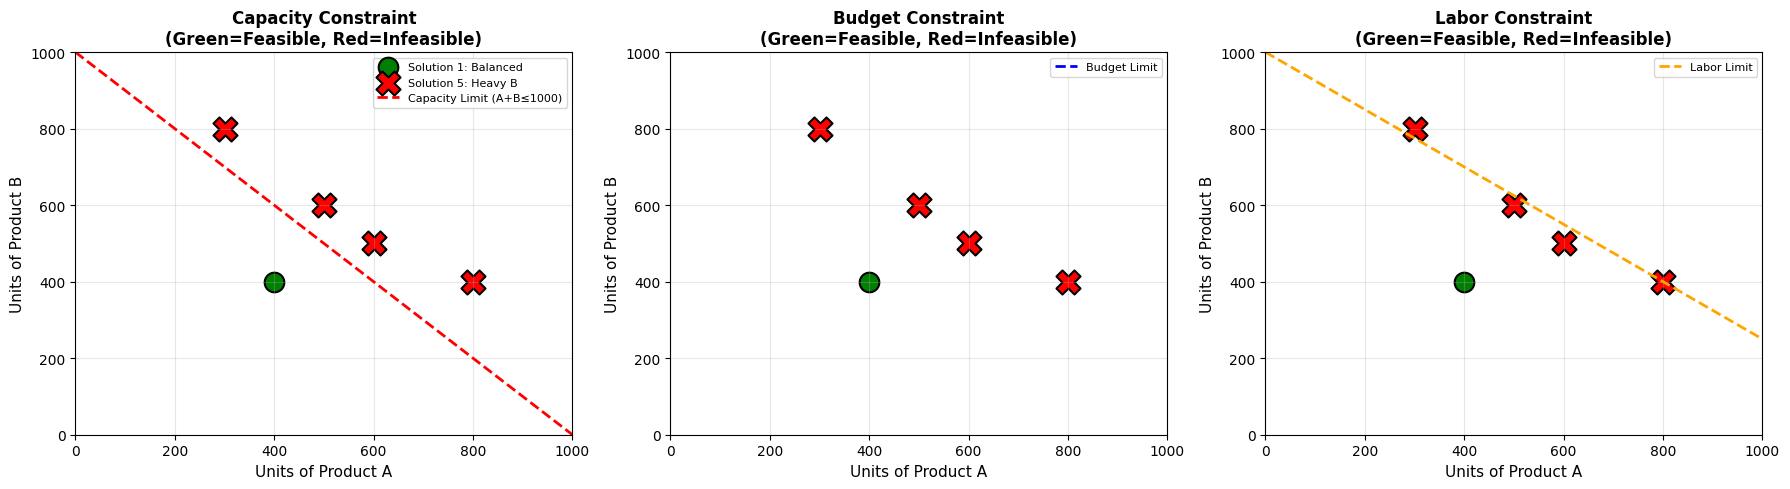


Key Insight:
  - Solutions below/on constraint lines satisfy that constraint
  - Solutions above constraint lines violate that constraint
  - Feasible solutions must satisfy ALL constraints simultaneously


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Capacity constraint
ax1 = axes[0]
for idx, row in results_df.iterrows():
    color = 'green' if row['Feasible'] == 'Yes' else 'red'
    marker = 'o' if row['Feasible'] == 'Yes' else 'X'
    size = 200 if row['Feasible'] == 'Yes' else 300
    ax1.scatter(row['A'], row['B'], c=color, marker=marker, s=size, 
                edgecolors='black', linewidth=1.5, label=row['Solution'] if idx == 0 or idx == len(results_df)-1 else "")

# Capacity constraint line: A + B <= 1000
A_line = np.linspace(0, 1000, 100)
B_capacity = max_capacity - A_line
ax1.plot(A_line, B_capacity, 'r--', linewidth=2, label='Capacity Limit (A+B≤1000)')

ax1.set_xlabel('Units of Product A', fontsize=11)
ax1.set_ylabel('Units of Product B', fontsize=11)
ax1.set_title('Capacity Constraint\n(Green=Feasible, Red=Infeasible)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=8)
ax1.set_xlim(0, 1000)
ax1.set_ylim(0, 1000)

# Plot 2: Budget constraint
ax2 = axes[1]
for idx, row in results_df.iterrows():
    color = 'green' if row['Feasible'] == 'Yes' else 'red'
    marker = 'o' if row['Feasible'] == 'Yes' else 'X'
    size = 200 if row['Feasible'] == 'Yes' else 300
    ax2.scatter(row['A'], row['B'], c=color, marker=marker, s=size, 
                edgecolors='black', linewidth=1.5)

# Budget constraint: cost_A*A + cost_B*B <= 100000
# Solving for B: B <= (100000 - cost_A*A) / cost_B
B_budget = (max_budget - cost_A * A_line) / cost_B
B_budget = np.maximum(0, B_budget)
ax2.plot(A_line, B_budget, 'b--', linewidth=2, label='Budget Limit')

ax2.set_xlabel('Units of Product A', fontsize=11)
ax2.set_ylabel('Units of Product B', fontsize=11)
ax2.set_title('Budget Constraint\n(Green=Feasible, Red=Infeasible)', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=8)
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 1000)

# Plot 3: Labor constraint
ax3 = axes[2]
for idx, row in results_df.iterrows():
    color = 'green' if row['Feasible'] == 'Yes' else 'red'
    marker = 'o' if row['Feasible'] == 'Yes' else 'X'
    size = 200 if row['Feasible'] == 'Yes' else 300
    ax3.scatter(row['A'], row['B'], c=color, marker=marker, s=size, 
                edgecolors='black', linewidth=1.5)

# Labor constraint: labor_per_A*A + labor_per_B*B <= 800
B_labor = (max_labor - labor_per_A * A_line) / labor_per_B
B_labor = np.maximum(0, B_labor)
ax3.plot(A_line, B_labor, 'orange', linestyle='--', linewidth=2, label='Labor Limit')

ax3.set_xlabel('Units of Product A', fontsize=11)
ax3.set_ylabel('Units of Product B', fontsize=11)
ax3.set_title('Labor Constraint\n(Green=Feasible, Red=Infeasible)', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper right', fontsize=8)
ax3.set_xlim(0, 1000)
ax3.set_ylim(0, 1000)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("  - Solutions below/on constraint lines satisfy that constraint")
print("  - Solutions above constraint lines violate that constraint")
print("  - Feasible solutions must satisfy ALL constraints simultaneously")


In [6]:
# Create optimization model
model = LpProblem("Production_Feasible", LpMaximize)

# Decision variables
produce_A = LpVariable("produce_A", lowBound=0, cat='Continuous')
produce_B = LpVariable("produce_B", lowBound=0, cat='Continuous')

# Objective: Maximize profit
model += profit_A * produce_A + profit_B * produce_B, "Total_Profit"

# Constraints (must be satisfied)
model += cost_A * produce_A + cost_B * produce_B <= max_budget, "Budget_Limit"
model += produce_A + produce_B <= max_capacity, "Capacity_Limit"
model += labor_per_A * produce_A + labor_per_B * produce_B <= max_labor, "Labor_Limit"

# Solve
model.solve()

# Get solution
optimal_A = value(produce_A)
optimal_B = value(produce_B)
optimal_profit = value(model.objective)

# Verify feasibility
optimal_cost = cost_A * optimal_A + cost_B * optimal_B
optimal_units = optimal_A + optimal_B
optimal_labor = labor_per_A * optimal_A + labor_per_B * optimal_B

print("OPTIMIZATION RESULT:")
print("=" * 60)
print(f"  Produce {optimal_A:.1f} units of Product A")
print(f"  Produce {optimal_B:.1f} units of Product B")
print(f"  Total Profit: ${optimal_profit:,.2f}")
print(f"\nFEASIBILITY CHECK:")
print(f"  Budget: ${optimal_cost:,.2f} <= ${max_budget:,} ✓" if optimal_cost <= max_budget else f"  Budget: ${optimal_cost:,.2f} > ${max_budget:,} ✗")
print(f"  Capacity: {optimal_units:.1f} <= {max_capacity} ✓" if optimal_units <= max_capacity else f"  Capacity: {optimal_units:.1f} > {max_capacity} ✗")
print(f"  Labor: {optimal_labor:.1f} <= {max_labor} ✓" if optimal_labor <= max_labor else f"  Labor: {optimal_labor:.1f} > {max_labor} ✗")
print(f"\nKey Insight:")
print(f"  - Optimization found a FEASIBLE solution (satisfies all constraints)")
print(f"  - Optimization will NEVER recommend an infeasible solution")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/91fe40c10aa54fa3b495ef29c1cc0c85-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/91fe40c10aa54fa3b495ef29c1cc0c85-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 17 RHS
At line 21 BOUNDS
At line 22 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
0  Obj -0 Dual inf 90 (2)
0  Obj -0 Dual inf 90 (2)
1  Obj 50000
Optimal - objective value 50000
Optimal objective 50000 - 1 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00

## Step 7: What Happens When Constraints Are Too Restrictive?

If constraints are too restrictive, no feasible solutions exist. This is called an **infeasible problem**:


In [7]:
# Scenario: Impossible constraints (too restrictive)
impossible_budget = 20000  # Very low budget
impossible_capacity = 2000  # High capacity requirement
impossible_labor = 500  # Very low labor

print("SCENARIO: Impossible Constraints")
print("=" * 60)
print(f"  Budget limit: ${impossible_budget:,} (was ${max_budget:,})")
print(f"  Capacity requirement: {impossible_capacity} units (was {max_capacity})")
print(f"  Labor limit: {impossible_labor} hours (was {max_labor})")
print(f"\nThese constraints are contradictory - no solution can satisfy all of them!")

# Create model with impossible constraints
model_impossible = LpProblem("Production_Impossible", LpMaximize)

produce_A_imp = LpVariable("produce_A_imp", lowBound=0, cat='Continuous')
produce_B_imp = LpVariable("produce_B_imp", lowBound=0, cat='Continuous')

model_impossible += profit_A * produce_A_imp + profit_B * produce_B_imp, "Total_Profit"

# Impossible constraints
model_impossible += cost_A * produce_A_imp + cost_B * produce_B_imp <= impossible_budget, "Budget_Limit"
model_impossible += produce_A_imp + produce_B_imp >= impossible_capacity, "Capacity_Requirement"  # Note: >= for requirement
model_impossible += labor_per_A * produce_A_imp + labor_per_B * produce_B_imp <= impossible_labor, "Labor_Limit"

# Try to solve
model_impossible.solve()

# Check status
status = model_impossible.status
print(f"\nOptimization Status: {status}")
print(f"  Status -1 = Infeasible (no solution exists)")
print(f"  Status 1 = Optimal (solution found)")

if status == -1:
    print(f"\n✓ Confirmed: Problem is INFEASIBLE")
    print(f"  No solution exists that satisfies all constraints")
    print(f"  The problem is not that optimization failed; the constraints are impossible")
else:
    print(f"\nSolution found (unexpected!)")


SCENARIO: Impossible Constraints
  Budget limit: $20,000 (was $100,000)
  Capacity requirement: 2000 units (was 1000)
  Labor limit: 500 hours (was 800)

These constraints are contradictory - no solution can satisfy all of them!
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e17f36da004f4ffba9285ed09125e8e1-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e17f36da004f4ffba9285ed09125e8e1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 17 RHS
At line 21 BOUNDS
At line 22 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with toler

## Step 8: Fixing an Infeasible Problem

When a problem is infeasible, you need to relax constraints. Let's see how:


In [8]:
# Fix: Relax constraints to make problem feasible
relaxed_budget = 50000  # Increased budget
relaxed_capacity = 800  # Reduced capacity requirement
relaxed_labor = 600  # Increased labor

print("FIXING INFEASIBLE PROBLEM: Relax Constraints")
print("=" * 60)
print(f"  Budget: ${impossible_budget:,} → ${relaxed_budget:,} (increased)")
print(f"  Capacity: {impossible_capacity} → {relaxed_capacity} (reduced requirement)")
print(f"  Labor: {impossible_labor} → {relaxed_labor} (increased)")

# Create model with relaxed constraints
model_fixed = LpProblem("Production_Fixed", LpMaximize)

produce_A_fix = LpVariable("produce_A_fix", lowBound=0, cat='Continuous')
produce_B_fix = LpVariable("produce_B_fix", lowBound=0, cat='Continuous')

model_fixed += profit_A * produce_A_fix + profit_B * produce_B_fix, "Total_Profit"

# Relaxed constraints
model_fixed += cost_A * produce_A_fix + cost_B * produce_B_fix <= relaxed_budget, "Budget_Limit"
model_fixed += produce_A_fix + produce_B_fix >= relaxed_capacity, "Capacity_Requirement"
model_fixed += labor_per_A * produce_A_fix + labor_per_B * produce_B_fix <= relaxed_labor, "Labor_Limit"

# Solve
model_fixed.solve()

optimal_A_fix = value(produce_A_fix)
optimal_B_fix = value(produce_B_fix)
optimal_profit_fix = value(model_fixed.objective)

print(f"\n✓ Problem is now FEASIBLE")
print(f"\n  Optimal Solution:")
print(f"    Produce {optimal_A_fix:.1f} units of A")
print(f"    Produce {optimal_B_fix:.1f} units of B")
print(f"    Total Profit: ${optimal_profit_fix:,.2f}")
print(f"\nKey Insight:")
print(f"  - When problem is infeasible, relax constraints to allow solutions")
print(f"  - Optimization can then find feasible solutions")
print(f"  - The problem was the constraints, not optimization")


FIXING INFEASIBLE PROBLEM: Relax Constraints
  Budget: $20,000 → $50,000 (increased)
  Capacity: 2000 → 800 (reduced requirement)
  Labor: 500 → 600 (increased)
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/621448e18d2b4f03a5e913f6402ea080-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/621448e18d2b4f03a5e913f6402ea080-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 17 RHS
At line 21 BOUNDS
At line 22 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
0  Obj -0 Primal inf 800 (1) Dual inf 90 (2)
0  Obj -0 Primal inf 800 (1) Du

## Summary: Feasible vs Infeasible Solutions

**Feasible Solutions**:
- Satisfy all constraints
- Can be implemented in the real world
- Optimization only finds feasible solutions

**Infeasible Solutions**:
- Violate one or more constraints
- Cannot be implemented
- Optimization will not recommend them

**Infeasible Problems**:
- No feasible solutions exist (constraints are too restrictive)
- Optimization cannot find a solution
- Solution: Relax constraints or change the problem

**Critical insight**: 
- Optimization only finds feasible solutions
- If optimization cannot find a solution, the problem may be infeasible
- Understanding feasibility helps you interpret optimization results correctly

**Practical implication**:
- Ensure your constraints allow feasible solutions to exist
- If optimization fails, check if constraints are too restrictive
- Relax constraints or change the problem to enable solutions
